<h1 align="center" style="background-color:#616161;color:white">Linear Regression with SVM</h1>

Adapted from: https://github.com/nfmcclure/tensorflow_cookbook/tree/master/04_Support_Vector_Machines/03_Reduction_to_Linear_Regression


<h3 style="background-color:#616161;color:white">0. Setup</h3>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [15]:
# Root path
#root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
root = "/home/badrul/git/EventPrediction" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Common Libraries</div>

In [16]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
import time
#from datetime import timedelta # Deprecated

# Visualization
import matplotlib.pyplot as plt             # Quick
%matplotlib inline

# Misc
import random

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Page Specific Libraries</div>

In [17]:
# Data science (comment out if not needed)
#from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
from sklearn import metrics
from sklearn import preprocessing

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Declare Functions</div>

In [18]:
def getHiddenTestUsers(firstNPerc=1.0):
    con = sqlite3.connect(dbPath)
    c = con.cursor()

    # Get list of UserIDs 
    users = pd.read_sql_query("Select UserID from tblUsers Where tblUsers.TestUser = 1",con)

    fieldList="t, PeriodID, UserID, HrsFrom5pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t1,t2,t3,t4,t5,t10,t12hrs,t23_5hrs,t24hrs,t24_5hrs,t1wk,t2wks,t3wks,t4wks"
    testDf=pd.DataFrame(columns=[fieldList])  # Create an emmpty df
    periodsInAMonth=int(60/periodGranularity)*24*7*4

    totalRows=0
    
    for user in users.itertuples():
        # Get training dataset
        SqlStr="SELECT {} from tblTimeSeriesData where UserID = {}".format(fieldList,user.userID)
    
        df = pd.read_sql_query(SqlStr, con)
        df["PeriodID"] = df["PeriodID"].astype(int)
        df.sort_values(['PeriodID'])
        totalRows += len(df)
        # Caluclate period cutt-off
        cutoff = int(len(df)*firstNPerc)
        testDf = testDf.append(df.iloc[0:cutoff])[df.columns.tolist()]
 
    testDf["PeriodID"] =  testDf["PeriodID"].astype(int)
    testDf["UserID"] =  testDf["UserID"].astype(int)
    testDf.sort_values(['UserID','PeriodID'], inplace=True)
    return testDf


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [19]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']
periodGranularity = int(settingsDict['periodGranularity'])

<h3 style="background-color:#616161;color:white">1. Load data</h3>

In [20]:
fieldList="t, UserID, HrsFrom5pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t1,t2,t3,t4,t5,t10,t12hrs, t23_5hrs, t24hrs, t24_5hrs, t1wk,t2wks,t3wks,t4wks"
trainDf,testDf = cc.getTrainTestData(dbPath, fieldList)

#trainDf['t'].replace(to_replace='0', value='-1', inplace=True)
#testDf['t'].replace(to_replace='0', value='-1', inplace=True)
xTrain = trainDf.drop(['t','UserID'], 1).values
yTrain = trainDf['t'].values.astype(int)
# Change the 0's to -1
#yTrain = np.array([1 if y==1 else -1 for y in yTrain])
yTrain =yTrain.reshape(len(yTrain),1)

# Test data
xTest= testDf.drop(['t','UserID'], 1).values
yTest = testDf['t'].values.astype(int)
#yTrain_test = np.array([1 if y==1 else -1 for y in yTrain_test])
yTest=yTest.reshape(len(yTest),1)


# One-Hot version
yTrain_onehot = pd.get_dummies(trainDf['t']).values.astype(float)
# One-Hot version
yTest_onehot = pd.get_dummies(testDf['t']).values.astype(float)

Skipping user 73 as not enough periods (1882)
Skipping user 97 as not enough periods (0)


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Confirm dimensions</div>

In [21]:
numOfFeatures = np.shape(xTrain)[1]
np.shape(xTrain),np.shape(yTrain),np.shape(yTrain_onehot)

((3555306, 22), (3555306, 1), (3555306, 2))

In [22]:
np.shape(xTest), np.shape( yTest),np.shape(yTest_onehot)

((225571, 22), (225571, 1), (225571, 2))

<h3 style="background-color:#616161;color:white">2. Model One: Standard Logistic Regression</h3>

Adapted from: https://blog.altoros.com/using-logistic-and-softmax-regression-in-tensorflow.html

In [23]:
mnistMode = False
   
# Set parameters
learning_rate = 0.01
training_iteration = 30
display_step = 2

if mnistMode:
    # Import MINST data
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    batch_size = 100
    numOfFeatures=784 # 784 for MNIST
    numOfClasses=10
else:
    batch_size = max(int(np.size(yTrain_onehot)/100),50)
    numOfFeatures=22 # 784 for MNIST
    numOfClasses=2
    
# TF graph input
x = tf.placeholder("float", [None, numOfFeatures]) # mnist data image of shape 28*28=784
y = tf.placeholder("float", [None, numOfClasses]) # 0-9 digits recognition => 10 classes

# Create a model

# Set model weights
W = tf.Variable(tf.zeros([numOfFeatures, numOfClasses]))
b = tf.Variable(tf.zeros([numOfClasses]))

# Construct a linear model
model = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax
m=tf.matmul(x, W) + b

### Minimize error using cross entropy cost function ##

# This is a flippin nightmare due to incorrect versions online.
# This is wrong never use it: https://stackoverflow.com/questions/33712178/tensorflow-nan-bug
# cost_function = -tf.reduce_sum(y*tf.log(model)*1)

# This works but is numerically unstable: https://www.tensorflow.org/get_started/mnist/beginners#training
# cost_function = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), reduction_indices=[1]))

# This is the correct method: https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/mnist/mnist_softmax.py
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=m))

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for iteration in range(training_iteration):
        avg_cost = 0.
        if mnistMode:
            total_batch = int(mnist.train.num_examples/batch_size)
        else:
            total_batch = int(len(xTrain)/batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            if mnistMode:
                batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            else:
                batch_xs = xTrain[i*batch_size:(i*batch_size)+batch_size]
                batch_ys = yTrain_onehot[i*batch_size:(i*batch_size)+batch_size]                
            
            # Fit training using batch data
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost_function, feed_dict={x: batch_xs, y: batch_ys})/total_batch
        # Display logs per eiteration step
        #if iteration % display_step == 0:
        #    print ("Iteration:", '%04d' % (iteration + 1), "cost=", "{:.9f}".format(avg_cost))

    print ("Tuning completed!")

    # Evaluation function
    
    preds=tf.argmax(model, 1)
    correct_prediction = tf.equal(preds, tf.argmax(y, 1))   
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # Test the model
    if mnistMode:
        print ("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))
    else:
        print ("Accuracy:", accuracy.eval({x: xTest, y: yTest_onehot}))   
        # Get predictions
        predictions= sess.run(tf.argmax(model, 1),feed_dict={x: xTest})

        print(metrics.classification_report(np.argmax(yTest_onehot,1),predictions))
        print(metrics.confusion_matrix(np.argmax(yTest_onehot,1),predictions))
        print("* Precision = labelled as x / how many were actually x in the ones that were labelled")
        print("* Recall = labelled as x / how many were actually x in the dataset")

Tuning completed!
Accuracy: 0.939926
             precision    recall  f1-score   support

          0       0.95      0.99      0.97    207345
          1       0.75      0.39      0.51     18226

avg / total       0.93      0.94      0.93    225571

[[204959   2386]
 [ 11165   7061]]
* Precision = labelled as x / how many were actually x in the ones that were labelled
* Recall = labelled as x / how many were actually x in the dataset


<h3 style="background-color:#616161;color:white">3. Model Three: Support Vector Regression</h3>

In [24]:
# Set parameters
learning_rate = 0.01
training_iteration = 30
display_step = 2

batch_size = max(int(np.size(yTrain)/100),50)
numOfFeatures=22 # 784 for MNIST
numOfClasses=1
    
# TF graph input
x = tf.placeholder("float", [None, numOfFeatures]) # mnist data image of shape 28*28=784
y = tf.placeholder("float", [None, numOfClasses]) # 0-9 digits recognition => 10 classes

# Create a model

# Set model weights
W = tf.Variable(tf.zeros([numOfFeatures, numOfClasses]))
b = tf.Variable(tf.zeros([numOfClasses]))

# Construct a linear model
## model = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax
model = tf.add(tf.matmul(x, W), b)
m=tf.matmul(x, W) + b

# Declare loss function
# = max(0, abs(target - predicted) + epsilon)
# 1/2 margin width parameter = epsilon
epsilon = tf.constant([0.1])

# Margin term in loss - only anything a greater error than epsilon should count towards the loss: http://cs.adelaide.edu.au/~chhshen/teaching/ML_SVR.pdf
cost_function = tf.reduce_mean(tf.maximum(0., tf.subtract(tf.abs(tf.subtract(model, y)), epsilon)))
## cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=m))

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)


In [25]:
# Launch the graph
sess = tf.Session()

# Initializing the variables
init = tf.global_variables_initializer()
sess.run(init)

# Initializing the variables
init = tf.global_variables_initializer()
sess.run(init)

# Training cycle
for iteration in range(training_iteration):
    avg_cost = 0.
    total_batch = int(len(xTrain)/batch_size)

    # Loop over all batches
    for i in range(total_batch):
        batch_xs = xTrain[i*batch_size:(i*batch_size)+batch_size]
        batch_ys = yTrain[i*batch_size:(i*batch_size)+batch_size]                

        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost_function, feed_dict={x: batch_xs, y: batch_ys})/total_batch

    # Display logs per eiteration step
    #if iteration % display_step == 0:
    #    print ("Iteration:", '%04d' % (iteration + 1), "cost=", "{:.9f}".format(avg_cost))

print ("Training completed!")

Training completed!


In [26]:
predictions=[]
# Testing cycle
total_batch = int(len(xTest)/batch_size)

if np.mod(len(xTest),batch_size) != 0:
    # tf requires consistent inputs so need to pad
    rowsToPad=batch_size-np.mod(len(xTest),batch_size)
    padRows=np.zeros([rowsToPad,xTest.shape[1]])
    xTest = np.append(xTest,padRows,axis=0)
    padRows=np.zeros([rowsToPad,yTest.shape[1]])
    yTest = np.append(yTest,padRows,axis=0)
    total_batch += 1
 
# Loop over all batches
for i in range(total_batch):
    batch_xs = xTest[i*batch_size:(i*batch_size)+batch_size]
    batch_ys = yTest[i*batch_size:(i*batch_size)+batch_size]                

    p=1*sess.run(tf.greater_equal(model, 0.5),feed_dict={x: batch_xs,y: batch_ys})
    predictions= np.append(predictions,p)

n=len(xTest)-rowsToPad
xTest=xTest[0:n]
yTest=yTest[0:n]
predictions=predictions[0:n]

print(metrics.classification_report(yTest,predictions))
print(metrics.confusion_matrix(yTest,predictions))
print("* Precision = labelled as x / how many were actually x in the ones that were labelled")
print("* Recall = labelled as x / how many were actually x in the dataset")

             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97    207345
        1.0       0.77      0.59      0.67     18226

avg / total       0.95      0.95      0.95    225571

[[204055   3290]
 [  7478  10748]]
* Precision = labelled as x / how many were actually x in the ones that were labelled
* Recall = labelled as x / how many were actually x in the dataset


In [27]:
# Get data
testDf2 = getHiddenTestUsers(firstNPerc=0.5)  # Get the first half of everyones history
xTest = testDf2.drop(['t','UserID','PeriodID'], 1).values
yTest = testDf2['t'].values.astype(int)
yTest=yTest.reshape(len(yTest),1)

predictions=[]
total_batch = int(len(xTest)/batch_size)

if np.mod(len(xTest),batch_size) != 0:
    # tf requires consistent inputs so need to pad
    rowsToPad=batch_size-np.mod(len(xTest),batch_size)
    padRows=np.zeros([rowsToPad,xTest.shape[1]])
    xTest = np.append(xTest,padRows,axis=0)
    padRows=np.zeros([rowsToPad,yTest.shape[1]])
    yTest = np.append(yTest,padRows,axis=0)
    total_batch += 1
 
# Loop over all batches
for i in range(total_batch):
    batch_xs = xTest[i*batch_size:(i*batch_size)+batch_size]
    batch_ys = yTest[i*batch_size:(i*batch_size)+batch_size]                

    p=1*sess.run(tf.greater_equal(model, 0.5),feed_dict={x: batch_xs,y: batch_ys})
    predictions= np.append(predictions,p)

n=len(xTest)-rowsToPad
xTest=xTest[0:n]
yTest=yTest[0:n]
predictions=predictions[0:n]

print(metrics.classification_report(yTest,predictions))
print(metrics.confusion_matrix(yTest,predictions))
print("* Precision = labelled as x / how many were actually x in the ones that were labelled")
print("* Recall = labelled as x / how many were actually x in the dataset")

             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97    192600
        1.0       0.79      0.63      0.70     24633

avg / total       0.93      0.94      0.94    217233

[[188408   4192]
 [  9209  15424]]
* Precision = labelled as x / how many were actually x in the ones that were labelled
* Recall = labelled as x / how many were actually x in the dataset


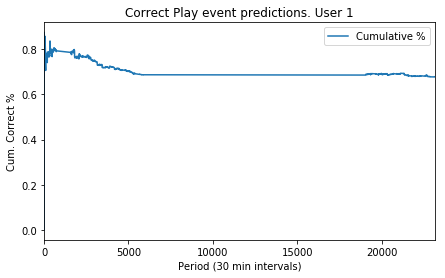

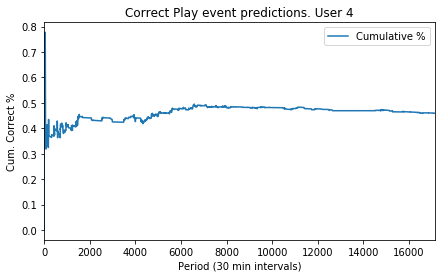

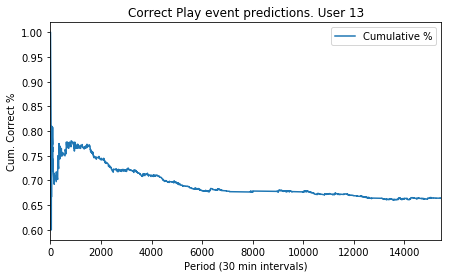

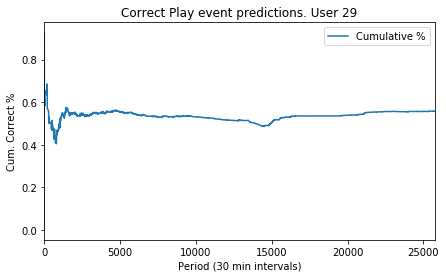

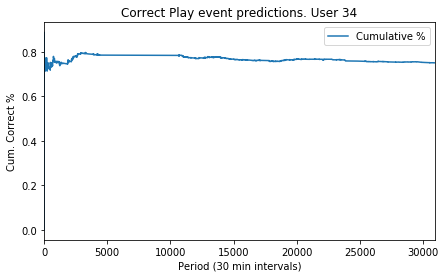

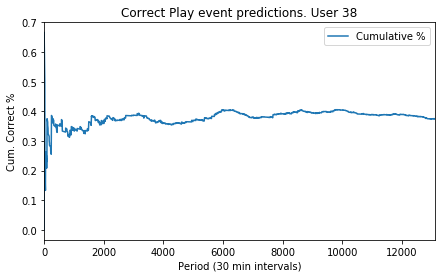

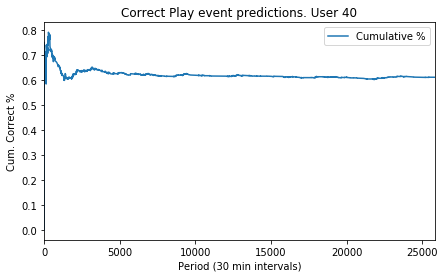

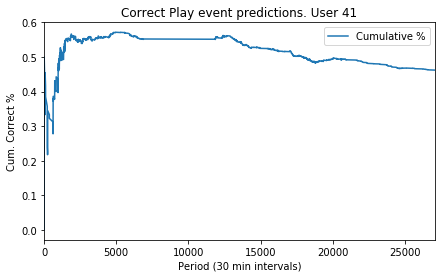

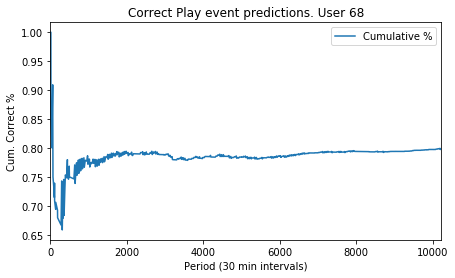

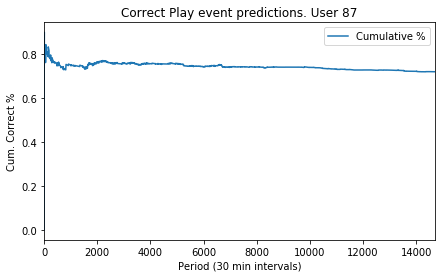

In [28]:
df=pd.DataFrame({'UserID': testDf2.UserID.values, 'Actual':yTest.reshape(-1,), 'Predicted':predictions.tolist()})
df['Period'] = df.index
df['Correct'] = (df['Actual'] == df['Predicted'])*1
df1 = df[df.Actual==1]
df1.set_index(['UserID','Period'],inplace=True)

df1= df1.assign(**{'Cum Correct': df1.groupby(level=0)["Correct"].cumsum()})
df1= df1.assign(**{'Cum Total': df1.groupby(level=0)["Actual"].cumsum()})
df1= df1.assign(**{'Cumulative %': df1.groupby(level=0)["Correct"].cumsum()/df1.groupby(level=0)["Actual"].cumsum()})

for u in df1.index.get_level_values(0).unique():
    tmp=df1.loc[u].head(5000)
    ax=tmp.plot(y='Cumulative %',title='Correct Play event predictions. User {}'.format(u),figsize=(7,4),x=(tmp.index.values - min(tmp.index.values)))
    ax.set_ylabel("Cum. Correct %")
    ax.set_xlabel("Period (30 min intervals)")